# STAC - Brazil South

This notebook aims to publish a FABDEM product for the South of Brasil, so it can be used "on-demand".<br>
Fabdem is made available from University of Bristol.
https://data.bris.ac.uk/data/dataset/s5hqmjcdj8yo2ibzi9b4ew3sn


## 1- Select the tiles

First step will be to select the tiles intersecting South region of Brasil. For that, we will first open the map tiles.

In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt

from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
tiles = gpd.read_file('../data/FABDEM_v1-2_tiles.geojson')

Then, we will load the Brazilian states

In [4]:
states = gpd.read_file('/Projects/data/shapes/states/BR_UF_2022.shp')

In [5]:
states.head()

,CD_UF,NM_UF,SIGLA_UF,NM_REGIAO,AREA_KM2,geometry
0,12,Acre,AC,Norte,164173.429,"POLYGON ((-68.79282 -10.99957, -68.79367 -10.9..."
1,13,Amazonas,AM,Norte,1559255.881,"POLYGON ((-56.76292 -3.23221, -56.76789 -3.242..."
2,15,Pará,PA,Norte,1245870.704,"MULTIPOLYGON (((-48.97548 -0.19834, -48.97487 ..."
3,16,Amapá,AP,Norte,142470.762,"MULTIPOLYGON (((-51.04561 -0.05088, -51.05422 ..."
4,17,Tocantins,TO,Norte,277423.627,"POLYGON ((-48.24830 -13.19239, -48.24844 -13.1..."


In [6]:
south = states[states['NM_REGIAO'] == 'Sul\n'].to_crs('epsg:4326').dissolve()

In [7]:
selected = tiles.loc[tiles.clip(south).index]

Text(0.5, 1.0, 'FABDEM Tiles')

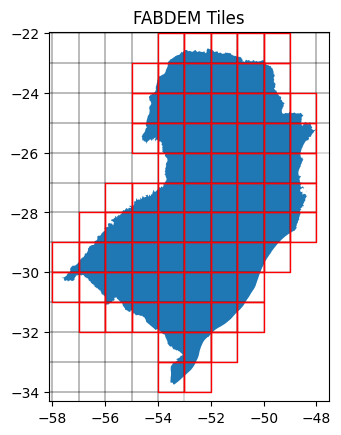

In [8]:
fig, ax = plt.subplots()

south.plot(ax=ax)
xmin, xmax, ymin, ymax = ax.axis()

tiles.plot(facecolor='none', linewidth=0.2, ax=ax)

selected.plot(facecolor='none', edgecolor='red', ax=ax)

ax.set_ylim((ymin, ymax))
ax.set_xlim((xmin, xmax))

ax.set_title('FABDEM Tiles')

## Collect selected tiles

The tiles were downloaded manually and are uncompressed locally. 

In [9]:
# list the zip files that need to be downloaded manually
selected['zipfile_name'].unique()

array(['S40W060-S-30W050_FABDEM_V1-2.zip',
       'S30W060-S-20W050_FABDEM_V1-2.zip',
       'S30W050-S-20W040_FABDEM_V1-2.zip'], dtype=object)

In [10]:
SRC_DIR = Path('/Projects/fabdem/tiles/')
DST_DIR = Path('/Projects/fabdem/brazil-south/')

In [11]:
# correct the filename for the extra 0
selected['file_name_corrected'] = selected['file_name'].str[0] + selected['file_name'].str[2:]

In [12]:
# loop trhough the selected tiles, check if they exist and move them to the ./brazil-south folder
# for idx, tile in selected.iterrows():
#     src = SRC_DIR/tile['file_name_corrected']

#     if src.exists():
#         dst = DST_DIR/tile['file_name']
#         #move it
#         src.rename(dst)
        

## Create the STAC Catalog

In [43]:
from datetime import datetime
import pystac
from pystac.extensions.projection import AssetProjectionExtension

import rasterio as rio

In [85]:
# first, we create the STAC catalog
catalog = pystac.Catalog(
    id='fabdem-brazil-south',
    description='Forest and Building removed DEM for the South of Brazil',
    stac_extensions=['https://stac-extensions.github.io/projection/v1.0.0/schema.json']
)

In [86]:
# create the STAC Items
# For that, we will iterate through the selected tiles

BASE_URL = 'https://github.com/cordmaur/fabdem-brazil-south/raw/main/tiles/'

for idx, tile in selected.iterrows():
    
    # open the dataset with rasterio
    ds = rio.open(DST_DIR/tile['file_name'])
    
    # # extract bounding box and footprint
    # bbox, footprint = get_bbox_and_footprint(ds)
    geometry = mapping(tile['geometry'])
    bbox = tile['geometry'].bounds
    
    # create the item
    item = pystac.Item(
        id=tile['file_name'][:-4],
        geometry=geometry,
        bbox=bbox,
        stac_extensions=['https://stac-extensions.github.io/projection/v1.0.0/schema.json'],
        properties=tile[['tile_name', 'file_name']].to_dict(),
        datetime=datetime.now()
    )
    
    # create the underlying asset
    item.add_asset(
    key='DEM',
        asset=pystac.Asset(
            title='fabdem',
            href=BASE_URL + tile['file_name'],
            media_type=pystac.MediaType.GEOTIFF
        )
        
    )
    
    # extend the asset with projection extension
    asset_ext = AssetProjectionExtension.ext(item.assets['DEM'])
    asset_ext.epsg = ds.crs.to_epsg()
    asset_ext.shape = ds.shape
    asset_ext.bbox = bbox
    asset_ext.geometry = geometry
    asset_ext.transform = [float(getattr(ds.transform, letter)) for letter in 'abcdef']
    
    # add the item to the catalog
    catalog.add_item(item)


In [87]:
catalog.normalize_hrefs(root_href='../stac_catalog')

In [92]:
catalog.save(pystac.CatalogType.SELF_CONTAINED)

## Test Catalog on GIT

Commit the catalog and make sure it is uploaded to github

In [ ]:
import pystac

In [96]:
online_catalog = pystac.Catalog.from_file(href='https://github.com/cordmaur/fabdem-brazil-south/raw/main/stac_catalog/catalog.json')

In [97]:
online_catalog

id: fabdem-brazil-south
description: Forest and Building removed DEM for the South of Brazil
type: Catalog
https://stac-extensions.github.io/projection/v1.0.0/schema.json
id: S033W053_FABDEM_V1-2
"bbox: [-53.0, -33.0, -52.0, -32.0]"
tile_name: S033W053
file_name: S033W053_FABDEM_V1-2.tif
datetime: 2023-10-24T15:25:34.822467Z
https://stac-extensions.github.io/projection/v1.0.0/schema.json
href: https://github.com/cordmaur/fabdem-brazil-south/raw/main/tiles/S033W053_FABDEM_V1-2.tif


In [63]:
ds = rio.open(item.assets['DEM'].href)

<open DatasetReader name='https://github.com/cordmaur/fabdem-brazil-south/raw/main/tiles/S033W053_FABDEM_V1-2.tif' mode='r'>

In [37]:
ds.crs.to_epsg()

4326

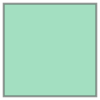

In [36]:
item.geometry

In [31]:
tile[['tile_name', 'file_name']]

tile_name                    S033W053
file_name    S033W053_FABDEM_V1-2.tif
Name: 18397, dtype: object

In [29]:
!ls

01-StacCreation-BrSouth.ipynb  __pycache__  utils.py


In [30]:
item

id: S033W053_FABDEM_V1-2
"bbox: (-53.0, -33.0, -52.0, -32.0)"
tile_name: S033W053
file_name: S033W053_FABDEM_V1-2.tif
zipfile_name: S40W060-S-30W050_FABDEM_V1-2.zip
"geometry: POLYGON ((-53 -33, -53 -32, -52 -32, -52 -33, -53 -33))"
file_name_corrected: S33W053_FABDEM_V1-2.tif
https://stac-extensions.github.io/projection/v1.0.0/schema.json
